In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import median_absolute_deviation, iqr
import pandas as pd
import statistics
from sklearn.neighbors import KernelDensity
import scipy.optimize as optimize
import scipy.integrate as integrate

In [132]:
N = 150
d1 = np.random.normal(loc = 1.0, scale = 1, size = N) # N(0, 1)
d2 = np.random.normal(loc = 0.0, scale = 1, size = N) # N(2, 1)

In [141]:
def calc_Silverman_bandwidth(data):
    IQR = iqr(data)
    s = statistics.stdev(data)
    s_star = min(s, IQR)
    N = len(data)
    h = 0.9*s_star*np.power(N, -0.2)
    return h

# an estimator for the bandwidth
# another way.
# bandwidth too big, also a big problem.
# provide two ways to users. This is also determined by data size.

In [134]:
def generate_models(d1, d2, band1, band2):
    # test_data = np.linspace(np.min(d1), np.max(d1), 1000)# Test Data Set
    pdf1 = KernelDensity(bandwidth=band1, kernel='gaussian')
    pdf1.fit(d1[:, None]) # (n, 1)

    pdf2 = KernelDensity(bandwidth=band2, kernel='gaussian')
    pdf2.fit(d2[:, None]) # (n, 1)
    return pdf1, pdf2

def generate_inital_theta(pdf1, pdf2, N):
    mean_1 = np.mean(pdf1.sample(N))
    mean_2 = np.mean(pdf2.sample(N))
    w = mean_1/mean_2
    b = mean_1 - w * mean_2
    return np.array([w, b])

In [135]:
band1 = calc_Silverman_bandwidth(d1)
band2 = calc_Silverman_bandwidth(d2)
pdf1, pdf2 = generate_models(d1, d2, band1, band2)

(1000,)


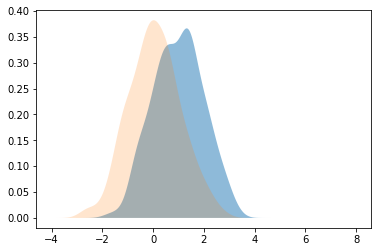

In [136]:
Wafer_Test = np.linspace(-4, 8, 1000)# Test Data Set
# Wafer_Test = np.reshape(pdf2.sample(1000), 1000)

logprob1 = pdf1.score_samples(Wafer_Test[:, None])
logprob2 = pdf2.score_samples(Wafer_Test[:, None])
plt.fill_between(Wafer_Test, np.exp(logprob1), alpha=0.5)
plt.fill_between(Wafer_Test, np.exp(logprob2), alpha=0.2)
print(np.shape(np.exp(logprob1)))

$\displaystyle \large \min \{ \sum (|\text{pdf1}(x)- \text{pdf2}(wx+b)|)\}$ \
\
\
暂时不考虑约束条件

In [137]:
test_data = pdf2.sample(2000) # test data for optimization
def opt_function(x):
#     test_data = Wafer_Test[:, None]
    res1 = np.exp(pdf1.score_samples(test_data))
    res2 = np.exp(pdf2.score_samples(test_data*x[0]+x[1]))
    return sum(abs(res1 - res2))

In [138]:
x0 = [1, 1]
res = optimize.minimize(opt_function, x0, method='Nelder-Mead', tol=1e-8,options={'disp': True})
res.x

Optimization terminated successfully.
         Current function value: 21.466685
         Iterations: 78
         Function evaluations: 149


array([ 0.94368547, -0.91925873])

In [139]:
opt_function(res.x)

21.466685114951115

(1000,)


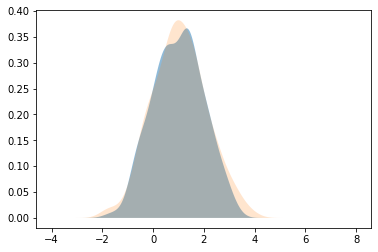

In [140]:
logprob1 = pdf1.score_samples(Wafer_Test[:, None])
# logprob2 = pdf2.score_samples(Wafer_Test[:, None]*res.x[0]+ res.x[1])
logprob2 = pdf2.score_samples(Wafer_Test[:, None]*res.x[0]+ res.x[1])
plt.fill_between(Wafer_Test, np.exp(logprob1), alpha=0.5)
plt.fill_between(Wafer_Test, np.exp(logprob2), alpha=0.2)
print(np.shape(np.exp(logprob1)))

In [130]:
def pdf_wapper(x, pdf, w, b):
    return np.exp(pdf.score_samples([[x*w+b]]))[0]

def cdf_calculation(pdf, w, b):
    return integrate.quad(pdf_wapper, -np.inf, np.inf, args=(pdf,w, b))

def BCMultiper(x, f1, f2, w, b):
    y = np.exp(f1.score_samples([[x]]))[0] * np.exp(f2.score_samples([[x*w+b]]))[0]
    return np.sqrt(y)

def BC(f1, f2, w, b):
    intgrl, abserr = cdf_calculation(pdf2, w, b)
#     if abs(intgrl - 1) > 1e-5:
#         return (0, 0)
    
    return integrate.quad(BCMultiper, -np.inf, np.inf, args=(pdf1,pdf2, w, b))

BC(pdf1, pdf2, 1, -1)
# cdf_calculation(pdf1, 1, 1)

(0.9903407198402913, 6.049755923606359e-09)

In [131]:
res.x[0], res.x[1]

(1.0484902635217077, -1.2698167327015353)

In [70]:
BC(pdf1, pdf2, res.x[0], res.x[1])

(0.9926077429914704, 7.486453581776576e-09)

$\large \displaystyle \min \{-\int \text{pdf1}(x) \cdot \text{pdf2}(wx+b) dx\}\\
\int \text{pdf1}(x) = 1, \int \text{pdf2}(wx+b)dx = 1 \\
\text{abs}(\int\text{pdf2}(wx+b)dx -1) \leq 10^{-5}
$

In [50]:
def BC2(f1, f2, w, b):
    intgrl, abserr = cdf_calculation(pdf2, w, b)
    if abs(intgrl - 1) > 1e-4:
        return (0, 0)
    
    return integrate.quad(BCMultiper, -np.inf, np.inf, args=(pdf1,pdf2, w, b))

def opt_function_int(x):
    intgrl, abserr = BC2(pdf1, pdf2, x[0], x[1])
    return -intgrl

In [54]:
res=optimize.minimize(opt_function_int, [1, -2], method='nelder-mead', tol=1e-8, options={'maxiter':200,'disp':True})
res.x

array([ 1.00009766, -1.88095703])

In [58]:
# opt_function_int(res.x)

In [57]:
BC(pdf1, pdf2, res.x[0], res.x[1])

(0.9932514098798351, 6.569739011683264e-09)

通过峰值判断

In [17]:
def pdf_wrapper_for_peak(x, pdf):
    return -np.exp(pdf.score_samples([x]))[0]

pdf_wrapper_for_peak([1], pdf1)

-0.37945526827438664

In [19]:
res1=optimize.minimize(pdf_wrapper_for_peak, [0], args=(pdf1,), method='nelder-mead',options={'xtol': 1e-10, 'disp':True})
res1.x

Optimization terminated successfully.
         Current function value: -0.384148
         Iterations: 46
         Function evaluations: 100


array([1.15002972])

In [108]:
abs(pdf1_wrapper(res1.x))

0.3805501773244744

In [109]:
def pdf2_wrapper(x):
    return -np.exp(pdf2.score_samples([x]))[0]

pdf2_wrapper([2])

-0.44223650932190667

In [110]:
res2=optimize.minimize(pdf2_wrapper, [0], method='nelder-mead',options={'xtol': 1e-10, 'disp':True})
res2.x

Optimization terminated successfully.
         Current function value: -0.447062
         Iterations: 47
         Function evaluations: 99


array([2.10622787])

In [111]:
abs(pdf2_wrapper(res2.x))

0.44706238739223847

In [112]:
res2.x - res1.x

array([1.28923755])

In [119]:
integrate.quad(pdf_wapper, -np.inf, res1.x[0], args=(pdf1, 1, 0))

(0.43685920601014927, 2.137507623244999e-09)

In [120]:
integrate.quad(pdf_wapper, -np.inf, res2.x[0], args=(pdf2, 1, 0))

(0.529927343147912, 7.641431292894731e-09)

In [121]:
0.43685920601014927/0.529927343147912

0.8243756651904149

CDF方法，通过解方程实现。然后，根据分位数，得到方程的解。

$\large \displaystyle x_2 = ax_1 + b$

In [150]:
def cdf1_wrapper(x, *q_v):
    v = q_v[0]
    return integrate.quad(pdf_wapper, -np.inf, x, args=(pdf1, 1, 0))[0] -v

def cdf2_wrapper(x, *q_v):
    v = q_v[0]
    return integrate.quad(pdf_wapper, -np.inf, x, args=(pdf2, 1, 0))[0] -v

In [151]:
optimize.fsolve(cdf1_wrapper, 0.1, args=(0.5))

array([0.98406564])

In [152]:
optimize.fsolve(cdf2_wrapper, 0.1, args=(0.5))

array([2.03918498])

In [153]:
optimize.fsolve(cdf1_wrapper, 0.1, args=(0.3))

array([0.44101427])

In [154]:
optimize.fsolve(cdf2_wrapper, 0.1, args=(0.3))

array([1.54768717])

In [155]:
a = (2.03918498 - 1.54768717) / (0.98406564-0.44101427)
a

0.9050668816101138

In [156]:
b = 2.03918498 - a*0.98406564
b

1.148539759905539

In [157]:
from sklearn import linear_model

In [158]:
model = linear_model.LinearRegression()
# nonlinear regression.

In [160]:
model.fit([[0.44101427], [0.98406564]],[[1.54768717],[2.03918498]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [162]:
model.coef_, model.intercept_

(array([[0.90506688]]), array([1.14853976]))

In [2]:
np.random.rand(1)

array([0.88697599])